In [226]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Reentry Chile Response Rate

*Sebastian Daza*

In this report we describe response rates by wave. We follow these general criteria:

- The estimation by wave only uses cases far beyond the wave-specific observation window. For instance, for the wave 2-months, we only consider those women who have been in the study for 4 months.
- This estimation is based on the administrative records of the study.

Some important definitions:

- Names of waves: baseline, week, two_months, six_months, twelve_months
- Variables names: `d` means date, `c` means clean, and `cd` clean date
- Deadline corresponds to th time threshold to compute a given response rate

We display key date variables to compute the rates and highlight inconsistencies or problems. 

In [227]:
# getting paths
import os
file = os.getcwd() + '/data/registroEncuestadorasGeneral.xlsx'

## Release
There are two date of release variables
in the register data. *Definitive* has a bunch of missing records. **We should define a validated and unique date for release**. 

In [228]:
import pandas as pd
import re 

In [229]:
# old code

# path = '/Users/sdaza/Desktop/seguimiento/'
# files = os.listdir(path)

#  # exclude temp files and DS_Store
# cfiles = [re.findall(r'^[a-zA-Z].+', file) for file in files]
# cfiles = list(filter(None, cfiles))
# cfiles

# # read data
# df = pd.DataFrame()
# for file in cfiles:
#     if file: 
#         t = pd.read_excel(path+file[0], skiprows=[0,1])
#         t.rename(columns=lambda x: x.strip(), inplace=True) # remove spaces
#         df = df.append(t, ignore_index=True)

In [230]:
# read excel file
df = pd.read_excel(file, skiprows=[0,1])

In [231]:
df.columns = df.columns.str.strip()

In [232]:
# extract columns
cols = ['enc','folio','fegresoefectiva', 'lb_fechaentrevista', 'lb_participa', 
       'primsem_fechaentrevista', 'primsem_participa', 'dosmeses_fechaentrevista', 
        'dosmeses_participa', 'seismeses_fechaentrevista', 'seismeses_participa', 
       'docemeses_fechaentrevista', 'docemeses_participa']

df = df.loc[:,cols]
df.shape

(226, 13)

In [233]:
# rename columns
names = ["int","id", "release_f","dbaseline","r_baseline",
         "dweek","r_week","d2months","r_2months",
         "d6months","r_6months","d12months","r_12months"]

df.rename(columns=dict(zip(cols, names)), inplace=True)

In [234]:
null = df.int.notnull()
df = df.loc[null, names]

In [235]:
df.shape

(226, 13)

In [236]:
# remove cases?
remove_cases = [10011,10015] # I guess this should be the same!

# df.id in remove_cases
df = df.loc[~df.id.isin(remove_cases),:]
df.shape

(224, 13)

In [237]:
# save data
import dill

dill.dump(df, open('registro.pkl', 'wb'))

# load the data
df = dill.load(open('registro.pkl', 'rb'))

In [238]:
# no valid records for release_f?
s = df.release_f.isnull()
s.value_counts()

False    224
Name: release_f, dtype: int64

In [239]:
#df.loc[s, 'release'] = df.loc[s, 'release_o']

In [240]:
# start = pd.to_datetime("09/01/2016")
# s = (df.release < start) & (df.release_o >= start)
# df.loc[s, ['release']] = df.loc[s, ['release_o']]
df['release_year'] = pd.DatetimeIndex(df['release_f']).year
df['release_month'] = pd.DatetimeIndex(df['release_f']).month

# year and months
print(df.release_year.value_counts())
print(df.release_month.value_counts())

2016    146
2017     78
Name: release_year, dtype: int64
10    72
12    34
3     30
11    28
1     28
2     20
9     12
Name: release_month, dtype: int64


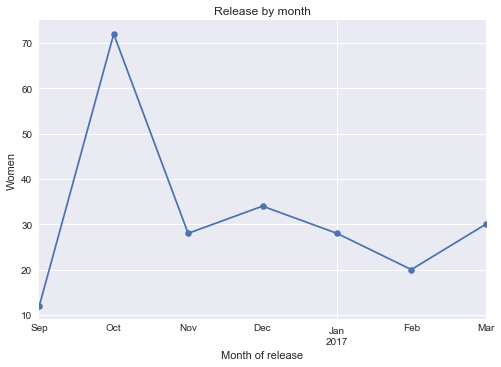

In [241]:
# release plot
t = df.reset_index().set_index('release_f')
t = t.resample('M')
ax = t.id.count().plot(title='Release by month', style='.-', ms=13);
ax.set_ylabel("Women");
ax.set_xlabel("Month of release");

## Baseline

Let's explore the baseline information. Below a plot with the distribution of the difference between the date of the baseline and release. All values should be **negative**. 

To check cases below where we have issues: missing data or positive value (i.e., the baseline was applied after release). 

In [242]:
# baseline response
# varname = [col for col in df.columns if 'sí: se realizó línea base' in col]
#print(varname)
# df = df.rename(columns={'lb_response': 'r_baseline'})
# df
# df.r_baseline.value_counts()
# df['r_baseline'] = df['r_baseline'].str.contains("s|S")

In [243]:
# correct some dates
df.loc[df.dbaseline.isnull(),['int','id', 'dbaseline', 'r_baseline']]

,int,id,dbaseline,r_baseline
63,Marisol,10291,NaN,Sí
104,Marcela,50060,NaN,0.708333


In [244]:
# error with id 20112
df.loc[df.id == 20112]
df.loc[df.id == 20112, 'dbaseline'] = '2016-10-19'

In [245]:
# function to clean dates
def clean_dates(text):
   if (isinstance(text, str)):
      text = str(text)
      pp = re.compile("-|\.")
      r = re.sub(pp, "/", text)
      pp = re.compile("([0-9]+/[0-9]+/[0-9]+)|([0-9]+-[0-9]+-[0-9]+)")
      r = re.search(pp, r)
      if (r is not None):
         r = r.group()
      else:
         r = ''
   else:
      r = text
   return pd.to_datetime(r, dayfirst=True, errors = 'coerce')

In [246]:
df['cdbaseline'] = [clean_dates(i) for i in df['dbaseline']]

In [247]:
# m = df['cdbaseline'].isnull() & df['dbaseline'].notnull()
# df.loc[m, ['int', 'id', 'cdbaseline', 'dbaseline']]

In [248]:
# replace errors in data entry
# errors = ['V16/12716', 'V14 y M18/10']
# new_values = ['12/16/16', '10/18/16']
# 
# for i in range(0,len(errors)):
#    df.loc[df['dbaseline'] == errors[i], 'cdbaseline'] = pd.to_datetime(new_values[i])

In [249]:
# identify inconsistent cases
# df.release_baseline.describe()
# ax = df.release_baseline.hist(bins = 40);
# ax.set_xlabel('Baseline date - Release');

In [250]:
df = df.assign(release_baseline = (df.cdbaseline - df.release_f).dt.days) # it has to be negative
s = ((df.release_baseline > 0) | (df.cdbaseline.isnull()))
df.loc[s, ['int', 'id', 'r_baseline', 'release_f',  'cdbaseline', 'dbaseline', 'release_baseline']].sort_values('id')

,int,id,r_baseline,release_f,cdbaseline,dbaseline,release_baseline
63,Marisol,10291,Sí,2017-03-22,NaT,NaN,NaN
84,Marcela,50037,SI,2016-10-19,2017-09-30,2017-09-30 00:00:00,346.0
104,Marcela,50060,0.708333,2016-10-19,NaT,NaN,NaN


Descriptives of the difference between release date and baseline: 

In [251]:
df.release_baseline.describe()

count    222.000000
mean     -11.540541
std       36.837366
min     -367.000000
25%      -14.000000
50%       -7.500000
75%       -4.000000
max      346.000000
Name: release_baseline, dtype: float64

## First week


Below a plot with the distribution of the difference between the date of the first week interview and release. All values should be **positive**. 


In [252]:
# varname = [col for col in df.columns if 'participa' in col]
# print(varname)

In [253]:
# df = df.rename(columns={varname[1]: 'r_week'})
#df.r_week.value_counts()
df['r_week'] = df['r_week'].str.contains("s|S").astype(float)
df['r_week'] = df.r_week.fillna(0)
#df.r_week.isnull().value_counts()
df.r_week.value_counts()

1.0    181
0.0     43
Name: r_week, dtype: int64

In [254]:
# varname = [col for col in df.columns if 'fecha' in col]
#print(varname)

In [255]:
# varname = [col for col in df.columns if 'fecha entrevista' in col]
#print(varname)

In [256]:
# df = df.rename(columns={varname[0]: 'dweek'})

In [257]:
df['cdweek'] = [clean_dates(i) for i in df['dweek']]
#df.cdweek.describe()

In [258]:
m = df.cdweek.isnull() & df.dweek.notnull()
# df.loc[m, ['id', 'cdweek', 'dweek']]

In [259]:
# # replace errors in data entry
# errors = ['S29/10 y W02/11']
# new_values = ['11/02/2016']

# for i in range(0,len(errors)):
#    df.loc[df['dweek'] == errors[i], 'cdweek'] = pd.to_datetime(new_values[i])

# s = (df.r_week == 1)
# #df.loc[s, 'cdweek'].isnull().value_counts()

In [260]:
df = df.assign(release_week = (df.cdweek - df.release_f).dt.days)
(df.release_week > 7).value_counts()

True     145
False     79
Name: release_week, dtype: int64

Plot of the difference between date of release and first week interview.

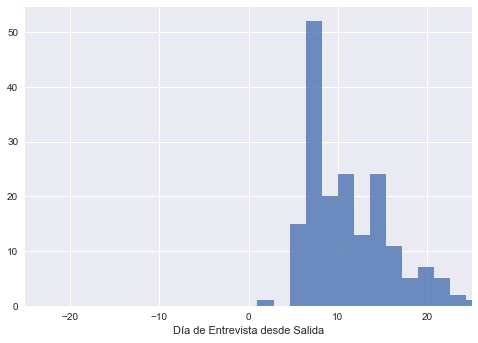

In [261]:
ax = df.release_week.hist(bins = 20, alpha = 0.8);
ax.set_xlim(-25,25)
ax.set_xlabel('Día de Entrevista desde Salida');

In [262]:
df['week_deadline'] = pd.DatetimeIndex( df['release_f'] ) + pd.DateOffset(weeks = 5) # five weeks!

Cases with issues: 

In [263]:
import datetime
today = datetime.datetime.now()
s = ((df.r_week == 1) & (today > df.week_deadline)) & ( (df.release_week <= 0) | (df.cdweek.isnull()) )

# df.loc[s,['int', 'id', 'r_week', 'release_f', 'cdweek', 'release_week']].sort_values('id')

In [264]:
df.loc[np.abs(df.release_week) > 30,['int', 'id', 'r_week', 'release_f', 'cdweek', 'release_week']]

,int,id,r_week,release_f,cdweek,release_week
194,Susana,10053,1.0,2016-10-19,2016-11-25,37.0


Interviews before the first 7 days:

In [265]:
df.loc[df.release_week < 7,['int', 'id', 'r_week', 'release_f', 'cdweek', 'release_week']]

,int,id,r_week,release_f,cdweek,release_week
100,Marcela,50216,1.0,2017-01-12,2017-01-13,1.0
108,Pati,20239,1.0,2017-02-01,2017-02-06,5.0
117,Pati,20181,1.0,2016-12-09,2016-12-15,6.0
169,Susana,40169,1.0,2016-12-02,2016-12-07,5.0
170,Susana,40156,1.0,2016-11-20,2016-11-25,5.0
176,Susana,40066,1.0,2016-10-19,2016-10-25,6.0
178,Susana,40152,1.0,2016-11-16,2016-11-22,6.0
179,Susana,40284,1.0,2017-03-15,2017-03-21,6.0
185,Susana,40122,1.0,2016-11-01,2016-11-07,6.0
189,Susana,40019,1.0,2016-10-01,2016-10-07,6.0


Response rate:

In [266]:
tab  = df.loc[ (today > df.week_deadline) | (df.r_week == 1), 'r_week'].value_counts()
rr_week = [i / sum(list(tab)) for i in tab][0]
print(rr_week)

0.808035714286


Descriptives of the difference between date of release and interview first week. 

In [267]:
df.loc[df.r_week == 1, 'release_week'].describe()

count    181.000000
mean      11.287293
std        4.932354
min        1.000000
25%        8.000000
50%       10.000000
75%       14.000000
max       37.000000
Name: release_week, dtype: float64


# Two Months
 

In [268]:
# varname = [col for col in df.columns if 'participa ' in col]
#print(varname)

In [269]:
# df = df.rename(columns={varname[0]: 'r_2months'})
#df.r_2months.value_counts()
df['r_2months'] = df['r_2months'].str.contains("s|S").astype(float)
df['r_2months'] = df.r_2months.fillna(0)
#df.r_2months.isnull().value_counts()
#df.r_2months.value_counts()

In [270]:
# date 2months
# varname = [col for col in df.columns if 'fecha entrevista' in col]
#print(varname)

In [271]:
# df = df.rename(columns={varname[0]: 'd2months'})

In [272]:
df['cd2months'] = [clean_dates(i) for i in df['d2months']]

Some cases with issues:

In [273]:
m = df.cd2months.isnull() & df.d2months.notnull()
df.loc[m, ['id', 'release', 'cd2months', 'd2months']]

,id,release,cd2months,d2months
71,50175,NaN,NaT,no hubo encuesta; Marisol


In [274]:
# replace errors in data entry
errors = ['27/2']
new_values = ['02/27/2017']

for i in range(0,len(errors)):
   df.loc[df['d2months'] == errors[i], 'cd2months'] = pd.to_datetime(new_values[i])

In [275]:
s = (df.r_2months == 1)
#df.loc[s, 'cd2months'].isnull().value_counts()

In [276]:
df = df.assign(release_2months = (df.cd2months - df.release_f).dt.days)
#df.release_2months.describe()

Plot of the difference between release and date of two-months interview.

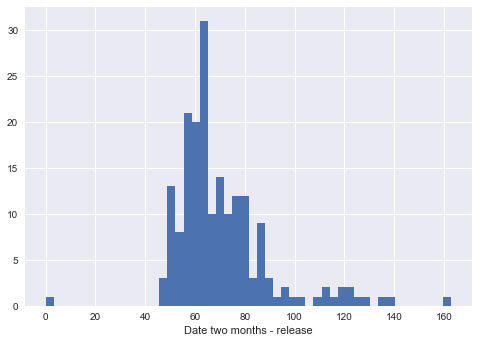

In [277]:
ax = df.release_2months.hist(bins = 50);
ax.set_xlabel('Date two months - release');

Some issues:

In [278]:
df['two_months_deadline'] = pd.DatetimeIndex( df['release_f'] ) + pd.DateOffset(months = 5)
s = ((df.r_2months == 1) & (today > df.two_months_deadline)) & ( (df.release_2months <= 0) | (df.cd2months.isnull()))
df.loc[s,['int', 'id', 'r_2months', 'release_f', 'cd2months', 'two_months_deadline', 'release_2months']].sort_values('id')

,int,id,r_2months,release_f,cd2months,two_months_deadline,release_2months


In [279]:
tab  = df.loc[ (today > df.two_months_deadline) | (df.r_2months == 1), 'r_2months'].value_counts()
# print(tab)
rr_2months = [i / sum(list(tab)) for i in tab][0]
# print(rr_2months)

In [280]:
df.loc[np.abs(df.release_2months) > 100,['int', 'id', 'r_2months', 'release_f', 
                                         'cd2months', 'two_months_deadline', 
                                         'release_2months']].sort_values('release_2months')

,int,id,r_2months,release_f,cd2months,two_months_deadline,release_2months
63,Marisol,10291,1.0,2017-03-22,2017-07-04,2017-08-22,104.0
105,Marcela,50249,1.0,2017-02-09,2017-05-30,2017-07-09,110.0
44,Javi,10233,1.0,2017-01-25,2017-05-17,2017-06-25,112.0
27,Javi,10087,1.0,2016-10-19,2017-02-09,2017-03-19,113.0
178,Susana,40152,1.0,2016-11-16,2017-03-11,2017-04-16,115.0
107,Marcela,50180,1.0,2016-12-07,2017-04-05,2017-05-07,119.0
115,Pati,20224,1.0,2017-01-16,2017-05-16,2017-06-16,120.0
74,Marisol,50271,1.0,2017-03-06,2017-07-06,2017-08-06,122.0
93,Marcela,50281,1.0,2017-03-12,2017-07-13,2017-08-12,123.0
98,Marcela,50205,1.0,2016-12-28,2017-05-03,2017-05-28,126.0


In [281]:
df.loc[np.abs(df.release_2months) < 10 ,['int', 'id', 
                                         'r_2months', 'release_f', 'cd2months', 
                                         'two_months_deadline', 
                                         'release_2months']].sort_values('release_2months')

,int,id,r_2months,release_f,cd2months,two_months_deadline,release_2months
67,Marisol,50104,0.0,2016-10-24,2016-10-24,2017-03-24,0.0


Descriptives:

In [282]:
df.loc[df.r_2months == 1, 'release_2months'].describe()

count    176.000000
mean      70.647727
std       19.335557
min       46.000000
25%       58.750000
50%       64.000000
75%       78.000000
max      163.000000
Name: release_2months, dtype: float64

## Six Months

In [283]:
#varname = [col for col in df.columns if 'participa ' in col]
#print(varname)

In [284]:
#df = df.rename(columns={varname[0]: 'r_6months'})
df.r_6months.value_counts()
df['r_6months'] = df['r_6months'].str.contains("s|S").astype(float)
df['r_6months'] = df.r_6months.fillna(0)
#df.r_6months.isnull().value_counts()
#df.r_6months.value_counts()

In [285]:
# date 6months
#varname = [col for col in df.columns if 'fecha entrevista' in col]
#print(varname)

In [286]:
#df = df.rename(columns={varname[0]: 'd6months'})
df['cd6months'] = [clean_dates(i) for i in df['d6months']]

m = df.cd6months.isnull() & df.d6months.notnull()
m.value_counts()

False    224
dtype: int64

In [287]:
# df.loc[m, ['id', 'release_f', 'cd6months', 'd6months']]

In [288]:
s = (df.r_6months == 1)
#df.loc[s, 'cd6months'].isnull().value_counts()

There is some issues here:

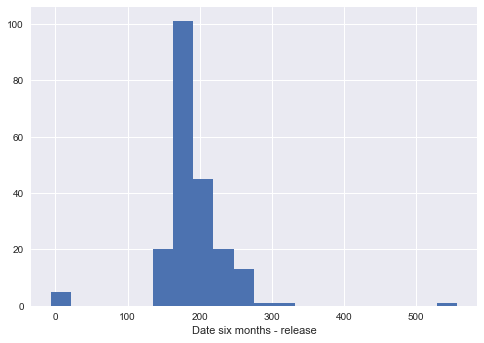

In [289]:
df.loc[df.id == 50209, 'cd6months'] = pd.to_datetime('2017-07-30') # is this right?
df = df.assign(release_6months = (df.cd6months - df.release_f).dt.days)

ax = df.release_6months.hist(bins = 20);
ax.set_xlabel('Date six months - release');

In [290]:
df['six_months_deadline'] = pd.DatetimeIndex( df['release_f'] ) + pd.DateOffset(months = 9)

s = ((df.r_6months == 1) & (today > df.six_months_deadline)) & (
    (df.release_6months <= 0) | (df.cd6months.isnull()))

df.loc[s,['int', 'id', 'r_6months', 'release_f', 'd6months', 
          'cd6months', 'six_months_deadline', 'release_6months']].sort_values('id')

,int,id,r_6months,release_f,d6months,cd6months,six_months_deadline,release_6months
71,Marisol,50175,1.0,2017-01-14,2017-01-08,2017-01-08,2017-10-14,-6.0


In [291]:
# df.loc[df.release_6months < -0,['int', 'id', 'r_6months', 'release_f', 'd6months', 'cd6months', 'six_months_deadline', 'release_6months']].sort_values('id')

In [292]:
df.loc[np.abs(df.release_6months) > 240, ['int', 'id', 'r_6months', 'release_f', 'cd6months', 
                                          'six_months_deadline', 
                                          'release_6months']].sort_values('release_6months')

,int,id,r_6months,release_f,cd6months,six_months_deadline,release_6months
67,Marisol,50104,1.0,2016-10-24,2017-06-27,2017-07-24,246.0
33,Javiera,30139,1.0,2016-11-04,2017-07-12,2017-08-04,250.0
104,Marcela,50060,1.0,2016-10-19,2017-06-26,2017-07-19,250.0
65,Marisol,50070,1.0,2016-10-22,2017-06-29,2017-07-22,250.0
177,Susana,10149,1.0,2016-11-14,2017-07-27,2017-08-14,255.0
39,Javiera,30021,1.0,2016-10-02,2017-06-21,2017-07-02,262.0
70,Marcela,50154,1.0,2016-11-18,2017-08-08,2017-08-18,263.0
86,Marcela,50150,1.0,2016-11-14,2017-08-08,2017-08-14,267.0
54,Javiera,30116,1.0,2016-10-19,2017-07-14,2017-07-19,268.0
69,Marisol,50133,1.0,2016-10-19,2017-07-18,2017-07-19,272.0


In [293]:
tab  = df.loc[(today > df.six_months_deadline)  | (df.r_6months == 1), 'r_6months'].value_counts()
# print(tab)
rr_6months = [i / sum(list(tab)) for i in tab][0]
print(rr_6months)

0.883408071749


Some descriptives:

In [294]:
df.loc[df.r_6months == 1, 'release_6months'].describe()

count    197.000000
mean     194.045685
std       42.895613
min       -6.000000
25%      170.000000
50%      186.000000
75%      208.000000
max      557.000000
Name: release_6months, dtype: float64

# Year

In [295]:
df.r_12months.value_counts()
df['r_12months'] = df['r_12months'].str.contains("s|S").astype(float)
df['r_12months'] = df.r_12months.fillna(0)

In [296]:
df.r_12months.value_counts()

0.0    118
1.0    106
Name: r_12months, dtype: int64

In [297]:
df['cd12months'] = [clean_dates(i) for i in df['d12months']]

m = df.cd12months.isnull() & df.d12months.notnull()
m.value_counts()

False    223
True       1
dtype: int64

In [298]:
s = (df.r_12months == 1)
s.value_counts()

False    118
True     106
Name: r_12months, dtype: int64

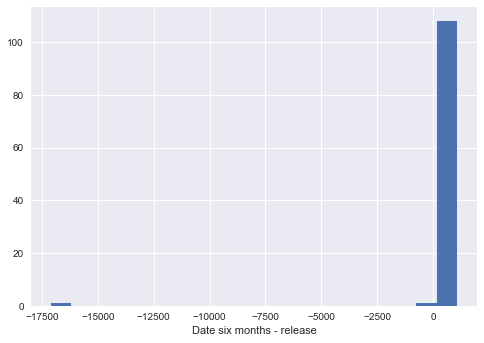

In [299]:
df = df.assign(release_12months = (df.cd12months - df.release_f).dt.days)

ax = df.release_12months.hist(bins = 20);
ax.set_xlabel('Date six months - release');

In [300]:
df['twelve_months_deadline'] = pd.DatetimeIndex( df['release_f'] ) + pd.DateOffset(months = 12)

s = ((df.r_12months == 1) & (today > df.twelve_months_deadline)) & (
    (df.release_12months <= 0) | (df.cd12months.isnull()))

df.loc[s,['int', 'id', 'r_12months', 'release_f', 'd12months', 
          'cd12months', 'twelve_months_deadline', 'release_12months']].sort_values('id')

,int,id,r_12months,release_f,d12months,cd12months,twelve_months_deadline,release_12months
65,Marisol,50070,1.0,2016-10-22,NaN,NaT,2017-10-22,NaN


In [301]:
tab  = df.loc[(today > df.twelve_months_deadline)  | (df.r_12months == 1), 'r_12months'].value_counts()
# print(tab)
rr_12months = [i / sum(list(tab)) for i in tab][0]
print(rr_12months)

0.741258741259


In [302]:
df.loc[np.abs(df.release_12months) > 380, ['int', 'id', 'r_12months', 'release_f', 'cd12months', 
                                          'twelve_months_deadline', 
                                          'release_12months']].sort_values('release_12months')

,int,id,r_12months,release_f,cd12months,twelve_months_deadline,release_12months
68,Marisol,50131,0.0,2016-10-19,1970-01-01,2017-10-19,-17093.0
173,Susana,10003,1.0,2016-09-16,2017-10-03,2017-09-16,382.0
180,Susana,40050,1.0,2016-10-19,2017-11-06,2017-10-19,383.0
153,Pati,20161,0.0,2016-11-18,2017-12-07,2017-11-18,384.0
162,Pati,10119,1.0,2016-10-17,2017-11-06,2017-10-17,385.0
60,Marisol,10074,1.0,2016-10-19,2017-11-09,2017-10-19,386.0
111,Pati,20081,1.0,2016-10-19,2017-11-09,2017-10-19,386.0
125,Pati,20071,1.0,2016-10-20,2017-11-12,2017-10-20,388.0
189,Susana,40019,1.0,2016-10-01,2017-10-26,2017-10-01,390.0
59,Marisol,10052,1.0,2016-10-19,2017-11-14,2017-10-19,391.0


In [303]:
df.loc[df.r_12months == 1, 'release_12months'].describe()

count     105.000000
mean      365.466667
std        74.631153
min       164.000000
25%       346.000000
50%       358.000000
75%       372.000000
max      1074.000000
Name: release_12months, dtype: float64

# Plot of interview days by wave

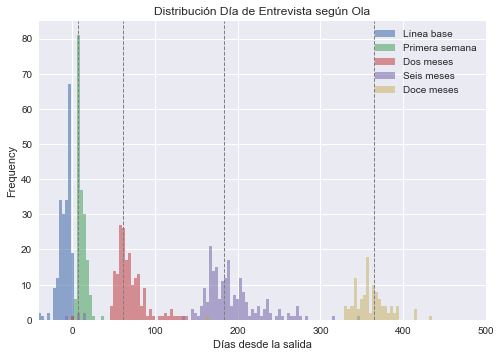

In [304]:
ax = df.loc[:, ['release_baseline', 'release_week', 'release_2months', 
                'release_6months', 'release_12months']].plot.hist(
    title='Distribución Día de Entrevista según Ola', alpha=0.6, bins = 5000)
ax.set_xlim(-40,500)
ax.legend(['Línea base', 'Primera semana', 'Dos meses', 'Seis meses', 'Doce meses'])
ax.axvline(7, color = 'gray', linestyle ='--', linewidth=1)
ax.axvline(30.5*2, color = 'gray', linestyle ='--', linewidth=1)
ax.axvline(30.5*6, color = 'gray', linestyle ='--', linewidth=1)
ax.axvline(365.0, color = 'gray', linestyle ='--', linewidth=1)
ax.set_xlabel('Días desde la salida');
plt.savefig('plots/dia_entrevista_ola.pdf', dpi = 600)

## Summary rates

In [305]:
rr = pd.DataFrame( {"rate" : [rr_week, rr_2months, rr_6months, rr_12months]}, 
                       index = ['week' ,'2 months', '6 months', '12 months'])

rr

,rate
week,0.808036
2 months,0.785714
6 months,0.883408
12 months,0.741259


In [306]:
# s = ['id', 'r_week', 'r_2months', 'r_6months', 'interviewer']
# df.loc[:,s].to_csv('/Users/sdaza/Dropbox/Projects/re-entry/10 investigadores/sdaza/reports-github/reports/data/clean_register.csv')